In [10]:
using Random
include("src/plotting_utils.jl")
include("src/guillotine_utils.jl")

sorted2midpoints (generic function with 1 method)

# Coarseness Guillotine Programación dinámica

El algoritmo completa la *tabla de memoización* de cuatro dimensiones $C(p,q,i,j)$ que contiene el valor de *guillotine-coarseness* del rectangulo formado por lineas medias entre puntos de $S$ con esquina inferior izquierda en las lineas $p,q$ (horizontal, vertical), anch $i$ y alto $j$. Ver `print_S_info(S,p,q,i,j)` para ejemplo.

Obs: $C(p,q,i,j)$ esta definido para $p=1:n$, $q=1:n$, $i=1:n-p+1$, $j=1:n-q+1$ y se calcula mediante la recurrencia

$$C(p,q,i,j) = \left\{\begin{array}{ll}
\infty & \text{ si $P(p,q,i,j)=0$}\\
1 & \text{ si $i=j=1$, $P(p,q,i,j)=1$}\\
max\left\{\begin{array}{l}D(p,q,i,j),\\
\displaystyle\max_{s=1:i-1}\{\min\{C(p,q,s,j), C(p+s,q,i-s,j)\}\}\\
\displaystyle\max_{t=1:j-1}\{\min\{C(p,q,i,t), C(p,q+t,i,j-t)\}\}\\
\end{array}\right. & \text{ si $i+j>1$, $P(p,q,i,j)\neq0$}\end{array}\right.$$

donde $P$ y $D$ son arreglos con las mismas dimensiones de $C$ que contienen respectivamente el número de puntos y la discrepancia para el rectangulo definido por $(p,q,i,j)$.

Obs: Hay que completar $C(p,q,i,j)$ en un orden tal que los rectangulos de dimensiones $s\times t$ con $s<i$ y $t<j$ esten calculados previamente, sino no funciona... 

Obs: El alguritmo como esta abajo calcula el bien (creo) el $C_g(S,w)=C(1,1,n,n)$, pero tiene aun un bugg que toma a veces partes sin puntos, hay que revisar por que. 

C[1,1,n,n]=2


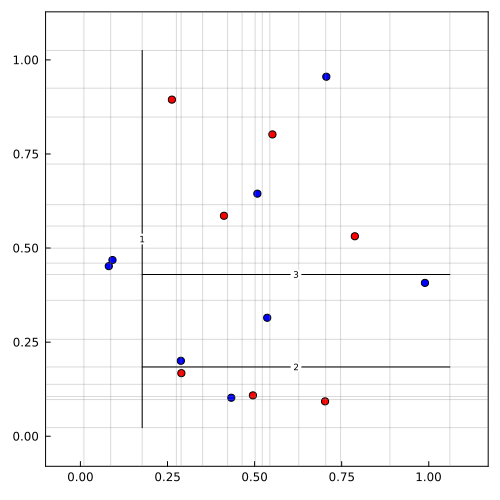

In [24]:
# Data generation ########################################################################
n = 15
S = rand(n,2)

#w = rand([-1,1], n)

half = n ÷ 2
w = shuffle([ones(Int,half)...,-ones(Int,n-half)...])


# Utils ##################################################################################
sortperm_x = sortperm(S[:, 1])
sorted_x = S[sortperm_x, 1]
midpoints_x = sorted2midpoints(sorted_x)

sortperm_y = sortperm(S[:, 2])
sorted_y = S[sortperm_y, 2]
midpoints_y = sorted2midpoints(sorted_y)

Disc_pqij(p,q,i,j) = abs(sum(w[intersect(sortperm_x[p:p+i-1],sortperm_y[q:q+j-1])]))
Count_pqij(p,q,i,j) = length(intersect(sortperm_x[p:p+i-1],sortperm_y[q:q+j-1]))

# Initialization #########################################################################
inf = 100
C = 100*ones(Int,n,n,n,n)
P = zeros(Int,n,n,n,n)
D = zeros(Int,n,n,n,n)

# 0 --> not calculated!
# 1 --> Discepancy
# 2 --> Vertical
# 3 --> Horizontal
argcuts = zeros(Int,n,n,n,n)

# 0   --> not calculated! or Discepancy
# 1:n --> midpoint index of v or h cut
idxcuts = zeros(Int,n,n,n,n)

for p = 1:n
    for q = 1:n
        for i = 1:n-p+1
            for j = 1:n-q+1
                P[p,q,i,j] = Count_pqij(p,q,i,j)
                D[p,q,i,j] = Disc_pqij(p,q,i,j)
            end
        end
        if P[p,q,1,1] != 0
            C[p,q,1,1] = D[p,q,1,1]
        end
    end
end

open("test.txt","w") do io
    print_C_pyramid(C, "      Initialization C[p,q,i,j]",io)
    println(io,"\n.\n.\n.\n")
    print_C_pyramid(P, "                     P[p,q,i,j]",io)
    println(io,"\n.\n.\n.\n")
    print_C_pyramid(D, "                     D[p,q,i,j]",io)
end

#print_C_pyramid(C, "      Initialization C[p,q,i,j]")

for i = 1:n
    for j = 1:n
        if i+j>2
            for p = 1:n-i+1
                for q = 1:n-j+1
                    # CREO QUE ESTE IF NO CAMBIA NADA; PERO EVITA HARTO CALCULO TRIVIAL
                    if P[p,q,i,j] != 0
                        
                        # vertical cut
                        if i > 1
                            v_cuts = [[C[p,q,s,j], C[p+s,q,i-s,j]][k] for s=1:i-1, k=1:2]
                            v_argmins = argmin(v_cuts, dims=2)
                            v_mins = v_cuts[v_argmins]
                            v_argmax = argmax(v_mins)
                            v_max = v_mins[v_argmax]
                        else
                            v_max = -1
                        end
                            
                        # horizontal cut
                        if j > 1
                            h_cuts =  [[C[p,q,i,t], C[p,q+t,i,j-t]][k] for t=1:j-1, k=1:2]
                            h_argmins = argmin(h_cuts, dims = 2)
                            h_mins = h_cuts[h_argmins]
                            h_argmax = argmax(h_mins)
                            h_max = h_mins[h_argmax]
                        else
                            h_max = -1
                        end
                        
                        #println("(p,q)=($p,$q) i=$i j=$j")    
                        mini = [D[p,q,i,j], v_max..., h_max...]
                        
                        C[p,q,i,j] = maximum(mini)
                        argcuts[p,q,i,j] = argmax(mini)
                        if argcuts[p,q,i,j] == 2
                            idxcuts[p,q,i,j] = v_argmax[1]
                        elseif argcuts[p,q,i,j] == 3
                            idxcuts[p,q,i,j] = h_argmax[1]
                        end
                            
                    end
                end
            end
        end
    end
end


#print_C_pyramid(argcuts, "                  argcuts[p,q,i,j]")

println("C[1,1,n,n]=$(C[1,1,n,n])")
fig = plot_rb_points(S, w)
plot_add_lines!(fig, S)
plot_guillotine_line!(fig,1,1,n,n)
fig